<a href="https://colab.research.google.com/github/EtiPeretz/Fashion-MNIST-CNN/blob/main/Assignment_2_Fashion_MNIST_CNN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment # 2, CNN over Fasion MNIST**

In this assignment you are required to develop a convolutional network and train it over the Fasion MNIST data, a collection of 28X28 black and white images, classified into 10 different classes of clothing items. For more information about Fashion MNIST you may refer to: 
https://github.com/zalandoresearch/fashion-mnist 

In [ ]:
# Loading Fashion MNIST

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset


import time
from torch.autograd import Variable
from matplotlib import pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [ ]:
# Use dataloaders for train and test (batch size is 4)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

In [ ]:
# The images are of 1, 28, 28 size (only one black-white channel)

trainset[0][0].shape

torch.Size([1, 28, 28])

# **Part 1**: Implementing a CNN network for Fashion MNIST
Here is what you need to do; you are encoureged to look at notebook "Notebook 11 - CIFAR CNN" when trying to complete the next steps.


Write a network CNNFMnist, that has the following architecture:

* Convolution with 10 3X3 filters
* Relu
* Max pool with 2X2
* Convolution with 5 3X3 filters
* Relu
* Convolution with 16 3X3 filters
* Relu
* Max pool with 2X2
* Liner, output size 128
* Relu
* Liner, output size 64
* Relu
* Liner, output size 10

In [ ]:
class CNNFMnist(nn.Module):

    def __init__(self):
        super(CNNFMnist, self).__init__()
        # define layers
        # define Convolution with 10 3X3 filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        # define Convolution with 5 3x3 filters
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=5 , kernel_size=3)
        # define Concolution with 16 3x3 filters 
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=16 , kernel_size=3)
        # Liner, output size 128
        self.fc1 = nn.Linear(in_features=256, out_features=128)
        # Liner, output size 64
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        # Liner, output size 10
        self.out = nn.Linear(in_features=64, out_features=10)

        # define loss function - use cross entropy
        self.criterion = nn.CrossEntropyLoss()
        # define the optimizer - use SGD
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum = 0.9)

    def forward(self, x):
        # Max pooling over a (2, 2) window and Relu
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # Relu
        x = F.relu(self.conv2(x))
        # Max pooling over a (2, 2) window and Relu
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        #print(x.shape)
        x = x.view(-1, self.num_flat_features(x))
        #print(x.shape)
        x = self.fc1(x)
        # Relu
        x = F.relu(x)
        # Relu
        x = F.relu(self.fc2(x))
        out = self.out(x)
        # Modify your CNNFMnist implementation to return the output of the 
        # layer one before last after Relu in addition to the final output
        return out, x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    

Write a code that trains the network with the FashionMNIST training dataset, for classification (use cross entropy and SGD).
Run the network for at least 10 epochs, over the entire dataset. Make sure to print the loss over the train set as well as the **test set** over time (say, every 1000 batches, but it's up to you), so you will know where you are during training. 

Note, measuring loss of test is similar to measuring loss over the train test. However, make sure not to run the test images in back propagation. Use them only in forward and calulate the average loss over the entire test set. Since it will make the training process run slower, you should measure loss for the test set only at the end of an epoch (so overall you get 10 loss values for the test set). You are encoureged to write a different function for claculating the loss of the test set, and then call it from the training procedure.


You should collect the loss values in an array, so you can plot then into two curves, one for train and one for test.

In addition, you should measure the time it takes you to train the network completely.



In [ ]:
def train(net, is_gpu, epoch):
  # training loop
  print('Start Training')
  # define loss function - use cross entropy
  criterion = nn.CrossEntropyLoss()
  running_loss = 0.0
  average_train_loss = 0.0
  total = len(trainloader.dataset)
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    
    if is_gpu:
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU

    # zero the parameter gradient
    net.optimizer.zero_grad()
    
    # forward + backward + optimize
    _, outputs = net(inputs)
    # use cross entropy
    loss = criterion(outputs, labels)
    loss.backward()
    # use SGD
    net.optimizer.step()

    # print statistics
    running_loss += loss.item()
    average_train_loss += loss.item()
    if (i+1) % 1000 == 0:
            # Make sure to print the loss over the train set over time
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
  # calculate the average loss entire data set
  average_train_loss /= total
  return average_train_loss
  

Write a function that evaluates the resulted model over the entire test data of FashionMNIST. Provide a single accuracy number.

In [ ]:
def test(net, is_gpu):
  correct = 0
  total = 0
  loss_of_test = 0
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # use the GPU instead of the CPU
        if is_gpu:
          images = images.cuda()  # -- for GPU
          labels = labels.cuda()  # -- for GPU
        _, outputs = net(images)
        loss_of_test += net.criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  # calulate the average loss over the entire test set
  loss_of_test /= len(testloader.dataset)
  # Make sure to print the loss over the test set over time
  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
  return loss_of_test

# **Part 2**: Training with a GPU 
You are requested to change your code to use the GPU instead of the CPU.
This can be easily done bu converting every torch.tensor to torch.cuda.tensor. 

Specific instructions:
* Change the hardware equipent of your colab notebook. To do that, go to the "Runtime" menu, and then to "Change runtime type". In the dialog box, change "Hardware accelerator" to GPU.
* Please follow the lines that were commented out with the comment    # -- For GPU
* Also, remove the lines that have the comment # -- For CPU

Train your network again, compare and report training times.

In [ ]:
def eval(net):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      if is_gpu:
        images = images.cuda()
        labels = labels.cuda()

        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()
  print('Accuracy of the network on the test images of FashionMnist: %d %%' % (100 * correct / total))


In [ ]:
def part1_and_part2():
    if is_gpu == True:
      net = CNNFMnist().cuda()
      type = "GPU"
    else:
      net = CNNFMnist()   
      type = "CPU"
    losses_of_train = []
    losses_of_test = [] 

    # measure the time it takes you to train the network completely
    start_time = time.time()
    # Run the network for at least 10 epochs
    for epoch in range(10):
      losses_of_train.append(train(net, is_gpu, epoch))
      losses_of_test.append(test(net, is_gpu))
    # plot then into two curves
    # one for train
    plt.plot(losses_of_train, label="train", color="blue")
    # one for test
    plt.plot(losses_of_test, label="test", color="red")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    # the end of the time it took to train the network
    end_time = time.time()
    total_time = end_time-start_time 
    print("By using %s takes %d." % (type, total_time))
    

# **Part 3**: Transfer Learning
Training data is a valuable resource, and sometimes there is not enough of it for training a neural netowrk at scale. To handle this situation, one approach is transfer learning, where we train our network on a different related task, and then switch to train it on the downstream task that we focus on. In this last part of the assignment, you are requested to pretrain your network on CIFAR-10, then train it on Fashion-MNIST, and measure its contribution to the results. To do that, please follow the steps:

**Step 1**

Modify your CNNFMnist implementation to return the output of the layer one before last after Relu (Linear layer of size 64, above) in addition to the final output. For example:

```
def forward(self, x):
  ...
  return h, out
```

 and train it on the training-set part of CIFAR-10. Use batch size of 4, and train it for at least 10 epochs. Note that CIFAR-10 images are of different shapes (3X32X32), therefore a conversion into 1X28X28 is needed. To do that, when you load CIFAR-10 using a torchvision Dataset, you can use the transformer torchvision.transforms.Grayscale(num_output_channels=1) in order to convert the images to a 1X32X32 grayscale volume:

```
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                    torchvision.transforms.ToTensor()]))
```
Then, from each 1X32X32 image, sample 10 1X28X28 images at random positions, and use them for training (*optional* - for data augmentation, if you want, you can also generate the reflection of each of the 10 images and add them the training set).

**Setp 2**

Once done, write a new Module CNNFMnist2, which uses CNNFMnist as one of its sub modules, followed by some additional layers. The output of CNNFMnist that goes into the next layer, should be the output of the 64 neuron one-before-last layer, as described above. CNNFMnist2 should have the following architecture:

* CNNFMnist
* Liner, output size 32
* Relu
* Liner, output size 16
* Relu
* Liner, output size 10

Make sure to allow the user to assign a pre-trained version CNNFMnist as a member of the module. For example:

```
class CNNFMnist2(nn.Module):
    def __init__(self, trained_cnnfmnist_model):
        super(CNNFMnist2, self).__init__()
        self.trained_cnnfmnist_model = trained_cnnfmnist_model
        self.fc1 = nn.Linear(64, 32)
        ...
```

**Step 3**

Train and eval CNNFMnist2 on Fashion-MNIST a few times:
- Using the pre-trained version of CNNFMnist.
- Using a fresh CNNFMnist instance (without training it).
- (Optional) Using the pre-trained version of CNNFMnist, after freezing its weights using the .eval() function.

Report on evaluation results (accuracy) for all of those cases.

In [ ]:
# Part 3, Step 2: new Module CNNFMnist2
# which uses CNNFMnist as one of its sub modules, followed by some additional layers.
class CNNFMnist2(nn.Module):

    def __init__(self, trained_cnnfmnist_model):
        super(CNNFMnist2, self).__init__()
        # Make sure to allow the user to assign a pre-trained version CNNFMnist as a member of the module.
        self.trained_cnnfmnist_model = trained_cnnfmnist_model
        # Liner, output size 32
        self.fc1 = nn.Linear(in_features=64, out_features=32)
        # Liner, output size 16
        self.fc2 = nn.Linear(in_features=32, out_features=16)
        # Liner, output size 10
        self.out = nn.Linear(in_features=16, out_features=10)

        # define loss function - use cross entropy
        self.criterion = nn.CrossEntropyLoss()
        # define the optimizer - use SGD
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    def forward(self, x):
        h, x = self.trained_cnnfmnist_model(x)
        # Relu
        x = F.relu(self.fc1(x))
        # Relu
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x, x

In [ ]:
def train_of_part3(model, dataloader, epoch):
  # training loop
  # define loss function - use cross entropy
  criterion = nn.CrossEntropyLoss()
  running_loss = 0.0
  average_train_loss = 0.0
  total = len(trainloader.dataset)
  for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        
        if is_gpu:
          inputs = inputs.cuda() # -- For GPU
          labels = labels.cuda() # -- For GPU

        # zero the parameter gradients
        model.optimizer.zero_grad()

        # forward + backward + optimize
        outputs, _ = model(inputs)
        loss = model.criterion(outputs, labels)
        loss.backward()
        model.optimizer.step()

        # print statistics
        running_loss += loss.item()
        average_train_loss += loss.item()
        if (i+1) % 1000 == 0:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
  # calculate the average loss entire data set
  average_train_loss /= total
  return average_train_loss, model 

In [ ]:
def part3():
  # Step 1
  trainPart3 = []
  # Train and eval CNNFMnist2 on Fashion-MNIST a few times:
  # train it for at least 10 epochs.
  for i in range(10):
    # train it on the training-set part of CIFAR-10
    train_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),transforms.CenterCrop(28),
                                    torchvision.transforms.ToTensor()]))
    trainPart3 = train_cifar10 + trainPart3
  train_loader_of_CIFAR10 = torch.utils.data.DataLoader(trainPart3, batch_size=64, shuffle=True)
  print(trainPart3[0][0].shape)

  # pre-trained version of CNNFMnist
  model_of_CNNFMnist = CNNFMnist().cuda()

  # pretrain your network on CIFAR-10
  for epoch in range(10):
    _, pre_train = train_of_part3(model_of_CNNFMnist, train_loader_of_CIFAR10, epoch)

  # Step 3: Train and eval CNNFMnist2 on Fashion-MNIST a few times:
  # - Using the pre-trained version of CNNFMnist.
  CNNFMnist_model2 = CNNFMnist2(pre_train).cuda()
  for epoch in range(10):
    _ = train(CNNFMnist_model2, is_gpu, epoch)

  eval(CNNFMnist_model2)

  # Using a fresh CNNFMnist instance
  print("fresh CNNFMnist")
  cnnmnist = CNNFMnist().cuda()
  cnnmnist2 = CNNFMnist2(cnnmnist).cuda()
  for epoch in range(10):
    _, net = train_of_part3(cnnmnist2, trainloader, epoch)

  eval(net)

  print("The Assignment2 is ended")
 

Start Training
[1,  1000] loss: 2.980
[1,  2000] loss: 1.205
[1,  3000] loss: 0.834
[1,  4000] loss: 0.702
[1,  5000] loss: 0.698
[1,  6000] loss: 0.633
[1,  7000] loss: 0.613
[1,  8000] loss: 0.595
[1,  9000] loss: 0.568
[1, 10000] loss: 0.560
[1, 11000] loss: 0.556
[1, 12000] loss: 0.485
[1, 13000] loss: 0.483
[1, 14000] loss: 0.473
[1, 15000] loss: 0.465
Accuracy of the network on the test images: 82 %
Start Training
[2,  1000] loss: 0.454
[2,  2000] loss: 0.449
[2,  3000] loss: 0.436
[2,  4000] loss: 0.435
[2,  5000] loss: 0.455
[2,  6000] loss: 0.452
[2,  7000] loss: 0.423
[2,  8000] loss: 0.418
[2,  9000] loss: 0.414
[2, 10000] loss: 0.407
[2, 11000] loss: 0.429
[2, 12000] loss: 0.396
[2, 13000] loss: 0.399
[2, 14000] loss: 0.388
[2, 15000] loss: 0.386
Accuracy of the network on the test images: 84 %
Start Training
[3,  1000] loss: 0.383
[3,  2000] loss: 0.386
[3,  3000] loss: 0.346
[3,  4000] loss: 0.384
[3,  5000] loss: 0.346
[3,  6000] loss: 0.368
[3,  7000] loss: 0.361
[3,  8

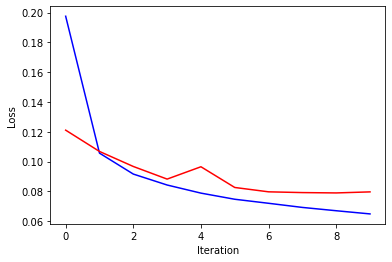

By using CPU takes 423.
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
torch.Size([1, 28, 28])


RuntimeError: ignored

In [ ]:
if __name__ == "__main__":
  is_gpu = True
  part1_and_part2()
  part3()

# Submission instructions

You should submit a pdf file with the following items:

First Name Last Name, ID

First Name2 Last Name2, ID

Link to Colab



CPU Experiment:
*   Plot of loss curves (train in blue, test in red)
*   Training time

GPU Experiment:
*   Plot of loss curves (train in blue, test in red)
*   Training time

Transfer Learning Experiment:
* Accuracy results on test set for the 2-3 implemeted settings (see above)



Good luck!